<a href="https://colab.research.google.com/github/202422/Focus-on-hyperparameter-tuning-House-Price-and-Titanic-Survival-Prediction/blob/main/All_Workflow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# **Machine learning pipeline: Focus on hyperparameter tuning**

This work covers the machine learning pipeline, from data preprocessing to training, evaluation, and making predictions, using both classification and regression problems. I'm making a focus on hyperparameter tuning by using techniques like Zooming In and Bayesian Optimization!!


* The **Zooming In** technique is a strategy where you refine the hyperparameter search space iteratively. Starting with a broad search space you perform an initial search (using GridSearchCV for example) to identify promising regions of the space. Then, in subsequent iterations, you narrow the range of hyperparameters (Zoom In) around the best-performing values from the previous step and search again. This approach balances exploration (finding promising regions) and exploitation (fine-tuning within those regions).
* **Bayesian Optimization** is a sequential optimization technique that efficiently finds the best hyperparameters by building a probabilistic model of the objective function and then selecting the promising hyperparameters. To Implement it, i'm going to use a technique called Tree-structured Parzen Estimators (TPE). Instead of modeling the objective function directly, TPE builds two probability distribution, one for good hyperparameters and another one for bad hyperparameters.




In [10]:
! pip install optuna

In [192]:
# Librairies Import
import optuna
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.neural_network import MLPClassifier, MLPRegressor
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, mean_squared_error, r2_score, mean_absolute_error
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, RandomForestRegressor, AdaBoostRegressor
from sklearn.svm import SVC, SVR
from sklearn.inspection import permutation_importance

## **Part 1: Data Preprocessing**

Before training machine learning models, we must prepare the dataset to ensure models can learn effectively.



### **Step 1: Load and Inspect Data**


To understand the dataset structure (columns, data types, missing values).
To identify any inconsistencies in the dataset.

In [12]:
# Load datasets
car_prices = pd.read_csv("car_price_dataset.csv")  # Regression dataset
titanic = pd.read_csv("titanic.csv")  # Classification dataset

# Display dataset information
print(car_prices.info())  # Shows column types and missing values
print(titanic.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Brand         10000 non-null  object 
 1   Model         10000 non-null  object 
 2   Year          10000 non-null  int64  
 3   Engine_Size   10000 non-null  float64
 4   Fuel_Type     10000 non-null  object 
 5   Transmission  10000 non-null  object 
 6   Mileage       10000 non-null  int64  
 7   Doors         10000 non-null  int64  
 8   Owner_Count   10000 non-null  int64  
 9   Price         10000 non-null  int64  
dtypes: float64(1), int64(5), object(4)
memory usage: 781.4+ KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 28 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Passengerid  1309 non-null   int64  
 1   Age          1309 non-null   float64
 2   Fare         1309 non-null 

In [13]:
# Show first few rows of car_prices dataset
car_prices.head()

,Brand,Model,Year,Engine_Size,Fuel_Type,Transmission,Mileage,Doors,Owner_Count,Price
0,Kia,Rio,2020,4.2,Diesel,Manual,289944,3,5,8501
1,Chevrolet,Malibu,2012,2.0,Hybrid,Automatic,5356,2,3,12092
2,Mercedes,GLA,2020,4.2,Diesel,Automatic,231440,4,2,11171
3,Audi,Q5,2023,2.0,Electric,Manual,160971,2,1,11780
4,Volkswagen,Golf,2003,2.6,Hybrid,Semi-Automatic,286618,3,3,2867


In [14]:
# Show first few rows of titanic dataset
titanic.head()

,Passengerid,Age,Fare,Sex,sibsp,zero,zero.1,zero.2,zero.3,zero.4,...,zero.12,zero.13,zero.14,Pclass,zero.15,zero.16,Embarked,zero.17,zero.18,Survived
0,1,22.0,7.2500,0,1,0,0,0,0,0,...,0,0,0,3,0,0,2.0,0,0,0
1,2,38.0,71.2833,1,1,0,0,0,0,0,...,0,0,0,1,0,0,0.0,0,0,1
2,3,26.0,7.9250,1,0,0,0,0,0,0,...,0,0,0,3,0,0,2.0,0,0,1
3,4,35.0,53.1000,1,1,0,0,0,0,0,...,0,0,0,1,0,0,2.0,0,0,1
4,5,35.0,8.0500,0,0,0,0,0,0,0,...,0,0,0,3,0,0,2.0,0,0,0


In [15]:
print("Car Prices Numeric Shape:", car_prices.shape,"\nTitanic Numeric Shape:", titanic.shape)

Car Prices Numeric Shape: (10000, 10) 
Titanic Numeric Shape: (1309, 28)


### **Step 2: Handle Missing Data**


*   Missing values can cause errors during training.
*   Some models (e.g., Decision Trees) can handle missing values, but others (e.g., Logistic Regression) cannot.
*   Strategies to handle missing data:

                 -> Numerical features → Replace with median.
                 -> Categorical features → Replace with mode (most frequent value).

In [16]:
# Checking presence of missing values in titanic dataset
titanic.isna().sum()

,0
Passengerid,0
Age,0
Fare,0
Sex,0
sibsp,0
zero,0
zero.1,0
zero.2,0
zero.3,0
zero.4,0


In [17]:
titanic.dropna(inplace=True)
titanic.isna().sum()

,0
Passengerid,0
Age,0
Fare,0
Sex,0
sibsp,0
zero,0
zero.1,0
zero.2,0
zero.3,0
zero.4,0


In [18]:
titanic.drop(columns = ["Passengerid"], inplace = True)

In [19]:
# Checking presence of missing values in car prices
car_prices.isna().sum()

,0
Brand,0
Model,0
Year,0
Engine_Size,0
Fuel_Type,0
Transmission,0
Mileage,0
Doors,0
Owner_Count,0
Price,0


## **Part 2: Feature engineering**

### **Step 1: Encoding Categorical Variables**

*   Machine learning models require numerical inputs.
*   Categorical features (e.g., 'Sex', 'Embarked') must be converted to numbers.

We use One-Hot Encoding, which creates binary columns for each category.

In [20]:
# Identify numerical and categorical columns separately
num_cols_car = car_prices.select_dtypes(include=['number']).columns
cat_cols_car = car_prices.select_dtypes(exclude=['number']).columns

num_cols_titanic = titanic.select_dtypes(include=['number']).columns
cat_cols_titanic = titanic.select_dtypes(exclude=['number']).columns

In [21]:
cat_cols_car

Index(['Brand', 'Model', 'Fuel_Type', 'Transmission'], dtype='object')

In [22]:
cat_cols_titanic

Index([], dtype='object')

In [23]:
# Removing Survived Column from dataset
num_cols_titanic = num_cols_titanic.drop("Survived")
num_cols_titanic

Index(['Age', 'Fare', 'Sex', 'sibsp', 'zero', 'zero.1', 'zero.2', 'zero.3',
       'zero.4', 'zero.5', 'zero.6', 'Parch', 'zero.7', 'zero.8', 'zero.9',
       'zero.10', 'zero.11', 'zero.12', 'zero.13', 'zero.14', 'Pclass',
       'zero.15', 'zero.16', 'Embarked', 'zero.17', 'zero.18'],
      dtype='object')

In [24]:
num_cols_car

Index(['Year', 'Engine_Size', 'Mileage', 'Doors', 'Owner_Count', 'Price'], dtype='object')

In [25]:
# Removing Price Column from dataset
num_cols_car = num_cols_car.drop("Price")
num_cols_car

Index(['Year', 'Engine_Size', 'Mileage', 'Doors', 'Owner_Count'], dtype='object')

In [26]:
# Encoding categorical variables of car prices dataset


encoder = OneHotEncoder(drop='first', sparse_output=False)
encoded_array = encoder.fit_transform(car_prices[cat_cols_car])
encoded_array

array([[0., 0., 0., ..., 0., 1., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [1., 0., 0., ..., 1., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.]])

In [27]:
# Converting array into DataFrame
encoded_df = pd.DataFrame(encoded_array, columns=encoder.get_feature_names_out(cat_cols_car))
encoded_df

,Brand_BMW,Brand_Chevrolet,Brand_Ford,Brand_Honda,Brand_Hyundai,Brand_Kia,Brand_Mercedes,Brand_Toyota,Brand_Volkswagen,Model_5 Series,...,Model_Sonata,Model_Sportage,Model_Tiguan,Model_Tucson,Model_X5,Fuel_Type_Electric,Fuel_Type_Hybrid,Fuel_Type_Petrol,Transmission_Manual,Transmission_Semi-Automatic
0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
9996,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
9997,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
9998,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [28]:
# Concatenating dataframes
car_prices_final = pd.concat([car_prices.drop(columns=cat_cols_car), encoded_df], axis=1)
car_prices_final

,Year,Engine_Size,Mileage,Doors,Owner_Count,Price,Brand_BMW,Brand_Chevrolet,Brand_Ford,Brand_Honda,...,Model_Sonata,Model_Sportage,Model_Tiguan,Model_Tucson,Model_X5,Fuel_Type_Electric,Fuel_Type_Hybrid,Fuel_Type_Petrol,Transmission_Manual,Transmission_Semi-Automatic
0,2020,4.2,289944,3,5,8501,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,2012,2.0,5356,2,3,12092,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,2020,4.2,231440,4,2,11171,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2023,2.0,160971,2,1,11780,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
4,2003,2.6,286618,3,3,2867,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,2004,3.7,5794,2,4,8884,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
9996,2002,1.4,168000,2,1,6240,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
9997,2010,3.0,86664,5,1,9866,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
9998,2002,1.4,225772,4,1,4084,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


### **Step 2: Feature Scaling**




*   Some models (e.g., KNN, Neural Networks) perform better when features are scaled.
*   StandardScaler transforms features to have mean = 0 and standard deviation = 1.


In [29]:
scaler_car = StandardScaler()
scaler_titanic = StandardScaler()

# Select only numerical columns
car_prices_numeric = car_prices[num_cols_car]
titanic_numeric = titanic[num_cols_titanic]

# Scale numerical features
car_prices_num_scaled = scaler_car.fit_transform(car_prices_numeric)
titanic_num_scaled = scaler_titanic.fit_transform(titanic_numeric)

In [30]:
car_prices_num_scaled

array([[ 1.22602090e+00,  1.04365690e+00,  1.63007524e+00,
        -4.47821193e-01,  1.41212224e+00],
       [ 6.61558054e-02, -8.70607405e-01, -1.66689517e+00,
        -1.34868861e+00,  6.25610429e-03],
       [ 1.22602090e+00,  1.04365690e+00,  9.52302614e-01,
         4.53046224e-01, -6.96676963e-01],
       ...,
       [-2.23810469e-01, -4.87267277e-04, -7.24936723e-01,
         1.35391364e+00, -1.39961003e+00],
       [-1.38367556e+00, -1.39267949e+00,  8.86638467e-01,
         4.53046224e-01, -1.39961003e+00],
       [-1.52865870e+00, -7.83595391e-01,  1.00128420e-01,
        -4.47821193e-01,  6.25610429e-03]])

In [31]:
# Replacing old values by scaled values
car_prices_scaled = car_prices_final.copy()
car_prices_scaled[num_cols_car] = car_prices_num_scaled
titanic_scaled = titanic.copy()
titanic_scaled[num_cols_titanic] = titanic_num_scaled

In [32]:
car_prices_scaled

,Year,Engine_Size,Mileage,Doors,Owner_Count,Price,Brand_BMW,Brand_Chevrolet,Brand_Ford,Brand_Honda,...,Model_Sonata,Model_Sportage,Model_Tiguan,Model_Tucson,Model_X5,Fuel_Type_Electric,Fuel_Type_Hybrid,Fuel_Type_Petrol,Transmission_Manual,Transmission_Semi-Automatic
0,1.226021,1.043657,1.630075,-0.447821,1.412122,8501,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,0.066156,-0.870607,-1.666895,-1.348689,0.006256,12092,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,1.226021,1.043657,0.952303,0.453046,-0.696677,11171,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.660970,-0.870607,0.135915,-1.348689,-1.399610,11780,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
4,-1.238692,-0.348535,1.591543,-0.447821,0.006256,2867,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,-1.093709,0.608597,-1.661821,-1.348689,0.709189,8884,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
9996,-1.383676,-1.392679,0.217346,-1.348689,-1.399610,6240,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
9997,-0.223810,-0.000487,-0.724937,1.353914,-1.399610,9866,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
9998,-1.383676,-1.392679,0.886638,0.453046,-1.399610,4084,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [33]:
titanic_scaled

,Age,Fare,Sex,sibsp,zero,zero.1,zero.2,zero.3,zero.4,zero.5,...,zero.12,zero.13,zero.14,Pclass,zero.15,zero.16,Embarked,zero.17,zero.18,Survived
0,-0.580261,-0.501839,-0.741900,0.480272,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.840447,0.0,0.0,0.622940,0.0,0.0,0
1,0.662297,0.736023,1.347891,0.480272,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,-1.550118,0.0,0.0,-1.833116,0.0,0.0,1
2,-0.269621,-0.488790,1.347891,-0.479537,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.840447,0.0,0.0,0.622940,0.0,0.0,1
3,0.429318,0.384512,1.347891,0.480272,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,-1.550118,0.0,0.0,0.622940,0.0,0.0,1
4,0.429318,-0.486373,-0.741900,-0.479537,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.840447,0.0,0.0,0.622940,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1304,-0.114301,-0.486373,-0.741900,-0.479537,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.840447,0.0,0.0,0.622940,0.0,0.0,0
1305,0.739957,1.463211,1.347891,-0.479537,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,-1.550118,0.0,0.0,-1.833116,0.0,0.0,0
1306,0.701127,-0.501839,-0.741900,-0.479537,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.840447,0.0,0.0,0.622940,0.0,0.0,0
1307,-0.114301,-0.486373,-0.741900,-0.479537,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.840447,0.0,0.0,0.622940,0.0,0.0,0


## **Part 3: Classification Task (Titanic Dataset)**

### **Step 1: Splitting Data**


To evaluate model performance, we split data into:

        Training set (80%) → Used to train models.
        Testing set (20%) → Used to evaluate models.

In [34]:
X = titanic_scaled.drop(columns=['Survived'])  # Features
y = titanic_scaled['Survived']  # Target variable

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify = y)


### **Step 2: Train Classification Models using Zooming In technique**


I'm applying Zooming In technique for each model separately

#### **Logistic Regression**

**First Iteration**

In [35]:
lr1 = LogisticRegression()
lr_grid1 = {'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000], 'penalty': ['l1', 'l2'], 'solver': ['liblinear']}
lr_grid_search1 = GridSearchCV(lr1, lr_grid1, cv=5)

In [36]:
lr_grid_search1.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=LogisticRegression(),
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
                         'penalty': ['l1', 'l2'], 'solver': ['liblinear']})

In [37]:
print("Le meilleur score:",lr_grid_search1.best_score_, "\Les meilleurs paramètres:",lr_grid_search1.best_params_)

Le meilleur score: 0.7961722488038279 \Les meilleurs paramètres: {'C': 0.1, 'penalty': 'l1', 'solver': 'liblinear'}


**Second Iteration**

In [38]:
lr2 = LogisticRegression()
lr_grid2 = {'C': [0.5, 1, 2, 5, 7], 'penalty': ['l2'], 'solver': ['liblinear']}
lr_grid_search2 = GridSearchCV(lr2, lr_grid2, cv=5)

In [39]:
lr_grid_search2.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=LogisticRegression(),
             param_grid={'C': [0.5, 1, 2, 5, 7], 'penalty': ['l2'],
                         'solver': ['liblinear']})

In [40]:
print("Le meilleur score:",lr_grid_search2.best_score_, "\Les meilleurs paramètres:",lr_grid_search2.best_params_)

Le meilleur score: 0.7952153110047846 \Les meilleurs paramètres: {'C': 0.5, 'penalty': 'l2', 'solver': 'liblinear'}


**Third Iteration**

In [41]:
lr3 = LogisticRegression()
lr_grid3 = {'C': [0.8, 1, 1.2, 1.8], 'penalty': ['l2'], 'solver': ['liblinear']}
lr_grid_search3 = GridSearchCV(lr3, lr_grid3, cv=5)

In [42]:
lr_grid_search3.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=LogisticRegression(),
             param_grid={'C': [0.8, 1, 1.2, 1.8], 'penalty': ['l2'],
                         'solver': ['liblinear']})

In [43]:
print("Le meilleur score:",lr_grid_search3.best_score_, "\Les meilleurs paramètres:",lr_grid_search3.best_params_)

Le meilleur score: 0.7952153110047846 \Les meilleurs paramètres: {'C': 0.8, 'penalty': 'l2', 'solver': 'liblinear'}


**Fourth iteration**

In [44]:
lr4 = LogisticRegression()
lr_grid4 = {'C': [0.7, 0.8, 0.9], 'penalty': ['l2'], 'solver': ['liblinear']}
lr_grid_search4 = GridSearchCV(lr4, lr_grid4, cv=5)

In [45]:
lr_grid_search4.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=LogisticRegression(),
             param_grid={'C': [0.7, 0.8, 0.9], 'penalty': ['l2'],
                         'solver': ['liblinear']})

In [46]:
print("Le meilleur score:",lr_grid_search4.best_score_, "\Les meilleurs paramètres:",lr_grid_search4.best_params_)

Le meilleur score: 0.7952153110047846 \Les meilleurs paramètres: {'C': 0.7, 'penalty': 'l2', 'solver': 'liblinear'}


**Fifth iteration**

In [47]:
lr5 = LogisticRegression()
lr_grid5 = {'C': [0.65, 0.7, 0.75], 'penalty': ['l2'], 'solver': ['liblinear']}
lr_grid_search5 = GridSearchCV(lr5, lr_grid5, cv=5)

In [48]:
lr_grid_search5.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=LogisticRegression(),
             param_grid={'C': [0.65, 0.7, 0.75], 'penalty': ['l2'],
                         'solver': ['liblinear']})

In [49]:
print("Le meilleur score:",lr_grid_search5.best_score_, "\Les meilleurs paramètres:",lr_grid_search5.best_params_)

Le meilleur score: 0.7952153110047846 \Les meilleurs paramètres: {'C': 0.65, 'penalty': 'l2', 'solver': 'liblinear'}


In [99]:
# Selecting final model
final_lr_model = lr_grid_search1.best_estimator_
final_lr_model

LogisticRegression(C=0.1, penalty='l1', solver='liblinear')

#### **KNN**

**First Iteration**

In [51]:
# KNN
knn1 = KNeighborsClassifier()
knn_grid1 = {'n_neighbors': [1, 5, 10, 15, 20, 25, 30, 35, 40]}
knn_grid_search1 = GridSearchCV(knn1, knn_grid1, cv=5)

In [52]:
knn_grid_search1.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': [1, 5, 10, 15, 20, 25, 30, 35, 40]})

In [53]:
print("Le meilleur score:",knn_grid_search1.best_score_, "\Les meilleurs paramètres:",knn_grid_search1.best_params_)

Le meilleur score: 0.7971291866028708 \Les meilleurs paramètres: {'n_neighbors': 30}


**Second Iteration**

In [54]:
# KNN
knn2 = KNeighborsClassifier()
knn_grid2 = {'n_neighbors': [11, 12, 13, 14, 15, 16, 17, 18, 19]}
knn_grid_search2 = GridSearchCV(knn1, knn_grid1, cv=5)

In [55]:
knn_grid_search2.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': [1, 5, 10, 15, 20, 25, 30, 35, 40]})

In [56]:
print("Le meilleur score:",knn_grid_search2.best_score_, "\Les meilleurs paramètres:",knn_grid_search2.best_params_)

Le meilleur score: 0.7971291866028708 \Les meilleurs paramètres: {'n_neighbors': 30}


In [57]:
# Selecting final model
final_knn_model = knn_grid_search2.best_estimator_
final_knn_model

KNeighborsClassifier(n_neighbors=30)

#### **Decision Tree**

**First Iteration**

In [58]:
dt1 = DecisionTreeClassifier(random_state = 4)
dt_grid1 = {'max_depth': [1, 4, 7, 10, 13, 16], 'min_samples_split': [2, 5, 10, 15, 20],
            'min_samples_leaf': [1, 2, 4, 6, 9, 12], 'criterion': ['gini', 'entropy']}
dt_grid_search1 = GridSearchCV(dt1, dt_grid1, cv=5)

In [59]:
dt_grid_search1.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=4),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [1, 4, 7, 10, 13, 16],
                         'min_samples_leaf': [1, 2, 4, 6, 9, 12],
                         'min_samples_split': [2, 5, 10, 15, 20]})

In [60]:
print("Le meilleur score:",dt_grid_search1.best_score_, "\Les meilleurs paramètres:",dt_grid_search1.best_params_)

Le meilleur score: 0.8028708133971291 \Les meilleurs paramètres: {'criterion': 'gini', 'max_depth': 4, 'min_samples_leaf': 1, 'min_samples_split': 15}


**Second Iteration**

In [61]:
dt2 = DecisionTreeClassifier(random_state = 4)
dt_grid2 = {'max_depth': [8, 9, 10, 11, 12], 'min_samples_split': [1, 2, 3, 4],
            'min_samples_leaf': [3, 4, 5], 'criterion': ['gini', 'entropy']}
dt_grid_search2 = GridSearchCV(dt2, dt_grid2, cv=5)

In [62]:
dt_grid_search2.fit(X_train, y_train)

/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:528: FitFailedWarning: 
150 fits failed out of a total of 600.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
150 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.11/dist-packages/sklearn/base.py", line 1382, in wrapper
    estimator._validate_params()
  File "/usr/local/lib/python3.11/dist-packages/sklearn/base.py", line 436, in _validate_params
    validate_parameter_constraints(
  File "/usr/local/lib/python3.11/dist-packages/sklearn/util

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=4),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [8, 9, 10, 11, 12],
                         'min_samples_leaf': [3, 4, 5],
                         'min_samples_split': [1, 2, 3, 4]})

In [63]:
print("Le meilleur score:",dt_grid_search2.best_score_, "\Les meilleurs paramètres:",dt_grid_search2.best_params_)

Le meilleur score: 0.7722488038277511 \Les meilleurs paramètres: {'criterion': 'entropy', 'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 2}


In [98]:
# Selecting final model
final_dt_model = dt_grid_search1.best_estimator_
final_dt_model

DecisionTreeClassifier(max_depth=4, min_samples_split=15, random_state=4)

#### **AdaBoost**

**First Iteration**

In [65]:
adaboost1 = AdaBoostClassifier(random_state = 4)
adaboost_grid1 = {'n_estimators': [50, 100, 150,200, 250], 'learning_rate': [0.01, 0.1, 1, 10]}
adaboost_grid_search1 = GridSearchCV(adaboost1, adaboost_grid1, cv=5)

In [66]:
adaboost_grid_search1.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=AdaBoostClassifier(random_state=4),
             param_grid={'learning_rate': [0.01, 0.1, 1, 10],
                         'n_estimators': [50, 100, 150, 200, 250]})

In [67]:
print("Le meilleur score:",adaboost_grid_search1.best_score_, "\Les meilleurs paramètres:",adaboost_grid_search1.best_params_)

Le meilleur score: 0.7866028708133971 \Les meilleurs paramètres: {'learning_rate': 1, 'n_estimators': 100}


**Second Iteration**

In [68]:
adaboost2 = AdaBoostClassifier(random_state = 4)
adaboost_grid2 = {'n_estimators': [200, 250, 300, 350], 'learning_rate': [0.5, 1, 2, 5, 8]}
adaboost_grid_search2 = GridSearchCV(adaboost2, adaboost_grid2, cv=5)

In [69]:
adaboost_grid_search2.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=AdaBoostClassifier(random_state=4),
             param_grid={'learning_rate': [0.5, 1, 2, 5, 8],
                         'n_estimators': [200, 250, 300, 350]})

In [70]:
print("Le meilleur score:",adaboost_grid_search2.best_score_, "\Les meilleurs paramètres:",adaboost_grid_search2.best_params_)

Le meilleur score: 0.7904306220095694 \Les meilleurs paramètres: {'learning_rate': 0.5, 'n_estimators': 300}


**Third Iteration**

In [71]:
adaboost3 = AdaBoostClassifier(random_state = 4)
adaboost_grid3 = {'n_estimators': [300, 350, 400, 450, 500], 'learning_rate': [0.8, 1, 1.2, 1.4]}
adaboost_grid_search3 = GridSearchCV(adaboost3, adaboost_grid3, cv=5)

In [72]:
adaboost_grid_search3.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=AdaBoostClassifier(random_state=4),
             param_grid={'learning_rate': [0.8, 1, 1.2, 1.4],
                         'n_estimators': [300, 350, 400, 450, 500]})

In [73]:
print("Le meilleur score:",adaboost_grid_search3.best_score_, "\Les meilleurs paramètres:",adaboost_grid_search3.best_params_)

Le meilleur score: 0.7961722488038278 \Les meilleurs paramètres: {'learning_rate': 1.2, 'n_estimators': 300}


**Fourth Iteration**

In [74]:
adaboost4 = AdaBoostClassifier(random_state = 4)
adaboost_grid4 = {'n_estimators': [450,500,550,600,650,700], 'learning_rate': [1, 1.2, 1.4, 1.6, 1.8, 2]}
adaboost_grid_search4 = GridSearchCV(adaboost4, adaboost_grid4, cv=5)

In [75]:
adaboost_grid_search4.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=AdaBoostClassifier(random_state=4),
             param_grid={'learning_rate': [1, 1.2, 1.4, 1.6, 1.8, 2],
                         'n_estimators': [450, 500, 550, 600, 650, 700]})

In [95]:
print("Le meilleur score:",adaboost_grid_search4.best_score_, "\nLes meilleurs paramètres:",adaboost_grid_search4.best_params_)

Le meilleur score: 0.7942583732057416 
Les meilleurs paramètres: {'learning_rate': 1.2, 'n_estimators': 450}


In [96]:
final_adaboost_model = adaboost_grid_search3.best_estimator_
final_adaboost_model

AdaBoostClassifier(learning_rate=1.2, n_estimators=300, random_state=4)

#### **SVC**

**First Iteration**

In [78]:
svc1 = SVC(random_state = 4)
svc_grid1 = {'C': [0.001, 0.01, 0.1, 1, 10, 100], 'kernel': ["linear", "poly", "rbf"], "gamma" : [0.01, 0.1, 1]}
svc_grid_search1 = GridSearchCV(svc1, svc_grid1, cv=5)

In [79]:
svc_grid_search1.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=SVC(random_state=4),
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100],
                         'gamma': [0.01, 0.1, 1],
                         'kernel': ['linear', 'poly', 'rbf']})

In [80]:
print("Le meilleur score:",svc_grid_search1.best_score_, "\nLes meilleurs paramètres:",svc_grid_search1.best_params_)

Le meilleur score: 0.7942583732057417 
Les meilleurs paramètres: {'C': 100, 'gamma': 0.01, 'kernel': 'rbf'}


**Second Iteration**

In [81]:
svc2 = SVC(random_state = 4)
svc_grid2 = {'C': [0.5, 1, 1.5, 2, 5], 'kernel': ["poly", "rbf"], "gamma" : [0.05, 0.1, 0.5, 0.9]}
svc_grid_search2 = GridSearchCV(svc2, svc_grid2, cv=5)

In [82]:
svc_grid_search2.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=SVC(random_state=4),
             param_grid={'C': [0.5, 1, 1.5, 2, 5],
                         'gamma': [0.05, 0.1, 0.5, 0.9],
                         'kernel': ['poly', 'rbf']})

In [83]:
print("Le meilleur score:",svc_grid_search2.best_score_, "\nLes meilleurs paramètres:",svc_grid_search2.best_params_)

Le meilleur score: 0.8 
Les meilleurs paramètres: {'C': 2, 'gamma': 0.1, 'kernel': 'rbf'}


**Third Iteration**

In [84]:
svc3 = SVC(random_state = 4)
svc_grid3 = {'C': [1, 1.3, 1.5, 1.8, 2, 2.2, 2.5, 2.7, 3], 'kernel': ["rbf"], "gamma" : [0.01, 0.03, 0.05, 0.07, 0.1, 0.15]}
svc_grid_search3 = GridSearchCV(svc3, svc_grid3, cv=5)

In [85]:
svc_grid_search3.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=SVC(random_state=4),
             param_grid={'C': [1, 1.3, 1.5, 1.8, 2, 2.2, 2.5, 2.7, 3],
                         'gamma': [0.01, 0.03, 0.05, 0.07, 0.1, 0.15],
                         'kernel': ['rbf']})

In [86]:
print("Le meilleur score:",svc_grid_search3.best_score_, "\nLes meilleurs paramètres:",svc_grid_search3.best_params_)

Le meilleur score: 0.8 
Les meilleurs paramètres: {'C': 1.8, 'gamma': 0.1, 'kernel': 'rbf'}


**Fourth Iteration**

In [87]:
svc4 = SVC(random_state = 4)
svc_grid4 = {'C': [2, 2.5, 2.8, 3, 3.3, 3.5, 3.8, 4, 4.5, 5], 'kernel': ["rbf"], "gamma" : [0.05]}
svc_grid_search4 = GridSearchCV(svc4, svc_grid4, cv=5)

In [88]:
svc_grid_search4.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=SVC(random_state=4),
             param_grid={'C': [2, 2.5, 2.8, 3, 3.3, 3.5, 3.8, 4, 4.5, 5],
                         'gamma': [0.05], 'kernel': ['rbf']})

In [89]:
print("Le meilleur score:",svc_grid_search4.best_score_, "\nLes meilleurs paramètres:",svc_grid_search4.best_params_)

Le meilleur score: 0.7971291866028709 
Les meilleurs paramètres: {'C': 2.8, 'gamma': 0.05, 'kernel': 'rbf'}


In [97]:
# Final model selection
final_svc_model = svc_grid_search3.best_estimator_
final_svc_model

SVC(C=1.8, gamma=0.1, random_state=4)

### **Step 3: Models Evaluation on Test Set**

We measure accuracy and other classification metrics.

Model: Logistic Regression

              precision    recall  f1-score   support

           0       0.81      0.88      0.84       194
           1       0.55      0.41      0.47        68

    accuracy                           0.76       262
   macro avg       0.68      0.65      0.66       262
weighted avg       0.74      0.76      0.75       262



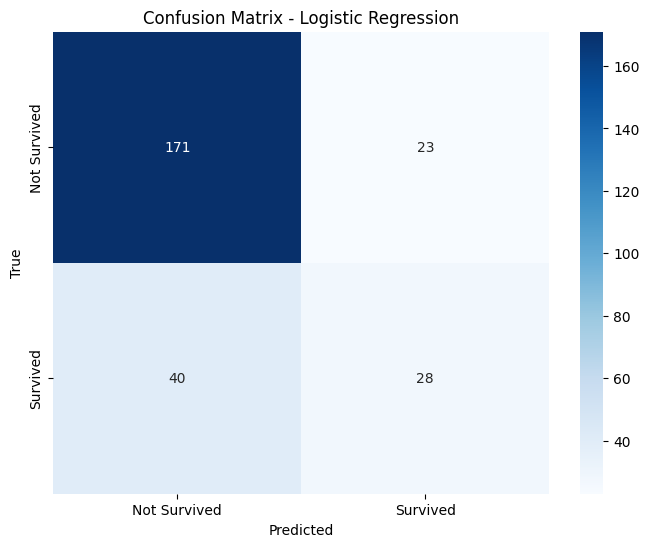

Model: KNN

              precision    recall  f1-score   support

           0       0.81      0.89      0.85       194
           1       0.56      0.40      0.47        68

    accuracy                           0.76       262
   macro avg       0.69      0.64      0.66       262
weighted avg       0.74      0.76      0.75       262



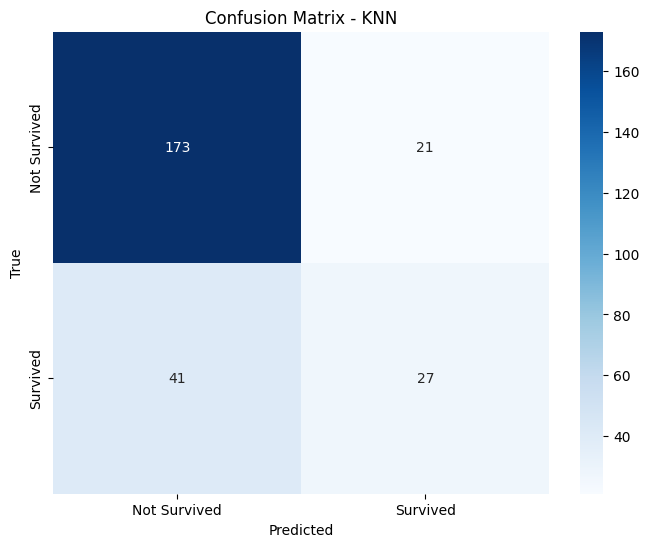

Model: Decision Tree

              precision    recall  f1-score   support

           0       0.82      0.86      0.84       194
           1       0.53      0.47      0.50        68

    accuracy                           0.76       262
   macro avg       0.68      0.66      0.67       262
weighted avg       0.75      0.76      0.75       262



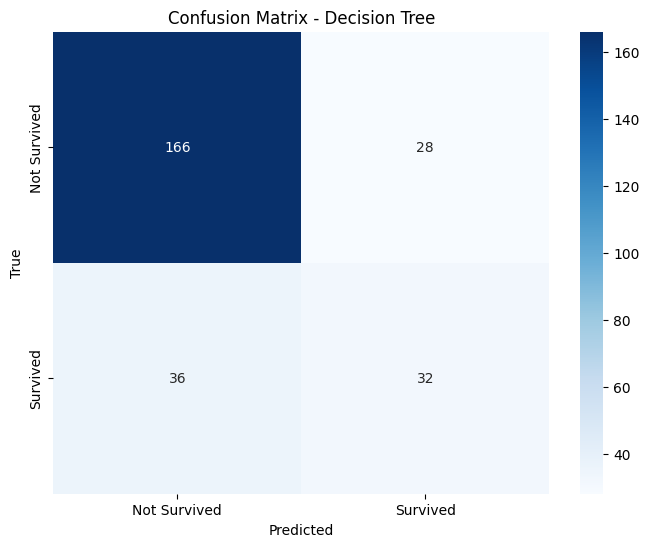

Model: AdaBoost

              precision    recall  f1-score   support

           0       0.82      0.88      0.85       194
           1       0.56      0.44      0.49        68

    accuracy                           0.76       262
   macro avg       0.69      0.66      0.67       262
weighted avg       0.75      0.76      0.75       262



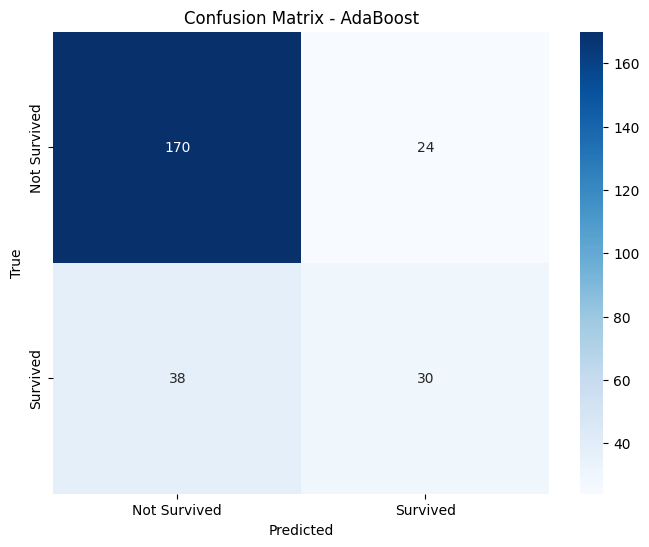

Model: SVC

              precision    recall  f1-score   support

           0       0.81      0.88      0.84       194
           1       0.55      0.43      0.48        68

    accuracy                           0.76       262
   macro avg       0.68      0.65      0.66       262
weighted avg       0.74      0.76      0.75       262



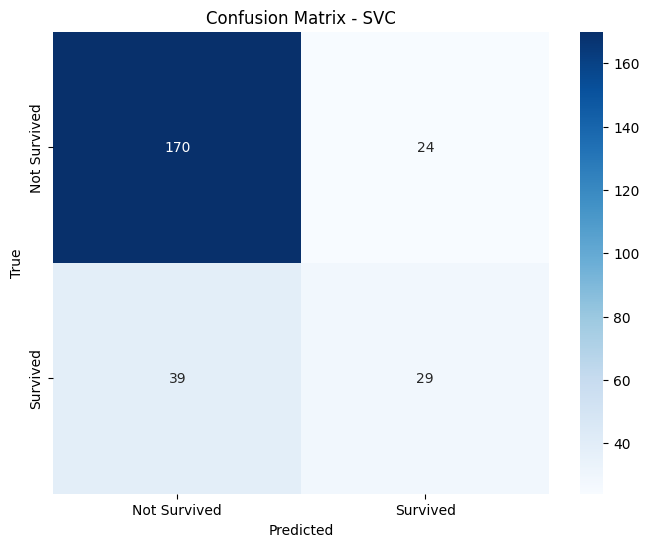

In [100]:
from sklearn.metrics import classification_report, confusion_matrix

classif_models = {'Logistic Regression': final_lr_model, 'KNN': final_knn_model, 'Decision Tree': final_dt_model,
                  "AdaBoost": final_adaboost_model, "SVC": final_svc_model}
for name, model in classif_models.items():
    y_pred = model.predict(X_test)
    print(f"Model: {name}\n")
    print(classification_report(y_test, y_pred))
    conf_mat = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Survived','Survived'], yticklabels=['Not Survived', "Survived"])
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(f'Confusion Matrix - {name}')
    plt.show()


**As we can see, confusion matrix shown that model AdaBoost is the one who best predicted , both classes.**

In [92]:
# Best classification model
best_classif_model = final_adaboost_model

In [93]:
# Feature importance in predicting Survival:
titanic_feature_names = X_train.columns

# create a dataframe
tit_feature_importance_df = pd.DataFrame({
    'Features': titanic_feature_names,
    'Importance': best_classif_model.feature_importances_
})

# Sorting by descending importance
tit_feature_importance_df = tit_feature_importance_df.sort_values(by='Importance', ascending=False)

tit_feature_importance_df

,Features,Importance
0,Age,0.259043
1,Fare,0.245597
11,Parch,0.159418
3,sibsp,0.144686
20,Pclass,0.098586
2,Sex,0.092670
6,zero.2,0.000000
7,zero.3,0.000000
4,zero,0.000000
5,zero.1,0.000000


Since AdaboostClassifier performed best on classification task, I'm going to train it again. But I will change hyperparameter tuning method by using **Bayesian Optimization based on Tree-Structured Parzen Estimator**.

In [101]:
# Defining objective function of AdaboostClassifier
def objective_adaboost(trial):
  n_estimators = trial.suggest_int("n_estimators", 100, 1000)
  learning_rate = trial.suggest_loguniform("learning_rate", 0.001, 100)

  adaboost_model = AdaBoostClassifier(n_estimators = n_estimators, learning_rate = learning_rate, random_state= 42)
  adaboost_model.fit(X_train, y_train)

  y_pred = adaboost_model.predict(X_test)
  accuracy = accuracy_score(y_test, y_pred)

  return -accuracy

In [102]:
# Running bayesian optimization
study_adaboost = optuna.create_study(direction = "minimize", sampler = optuna.samplers.TPESampler())
study_adaboost.optimize(objective_adaboost, n_trials = 50)

[I 2025-04-12 13:30:11,997] A new study created in memory with name: no-name-6bc68538-ef79-42ae-9817-ccb861b7fe6a
<ipython-input-101-61fc27192d93>:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 0.001, 100)
[I 2025-04-12 13:30:13,254] Trial 0 finished with value: -0.7595419847328244 and parameters: {'n_estimators': 466, 'learning_rate': 0.5919841011612289}. Best is trial 0 with value: -0.7595419847328244.
<ipython-input-101-61fc27192d93>:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 0.001, 100)
[I 2025-04-12 13:30:15,182] Trial 1 finished with value: -

In [103]:
print("Best hyperparameters:", study_adaboost.best_params)
print("Best accuracy value:", study_adaboost.best_value)

Best hyperparameters: {'n_estimators': 427, 'learning_rate': 0.9328830445906785}
Best accuracy value: -0.767175572519084


<ipython-input-104-ef2d539eb5f4>:2: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_optimization_history(study_adaboost)


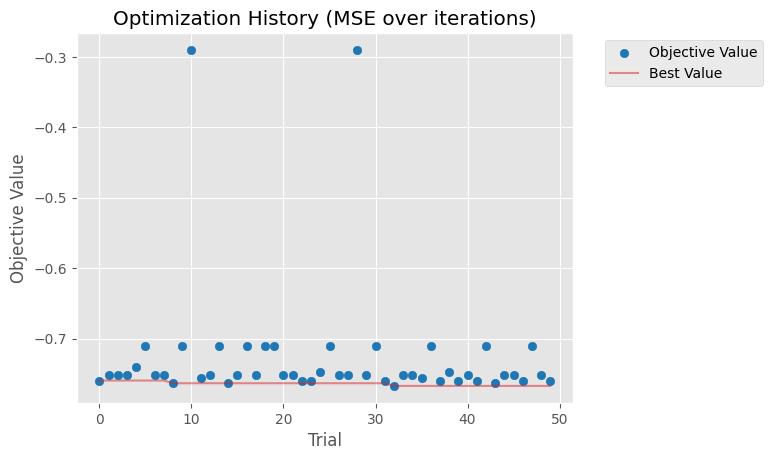

In [104]:
# Visualization of optimization history
optuna.visualization.matplotlib.plot_optimization_history(study_adaboost)
plt.title("Optimization History (MSE over iterations)")
plt.show()

<ipython-input-105-596fa7552eb7>:2: ExperimentalWarning: plot_param_importances is experimental (supported from v2.2.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_param_importances(study_adaboost)


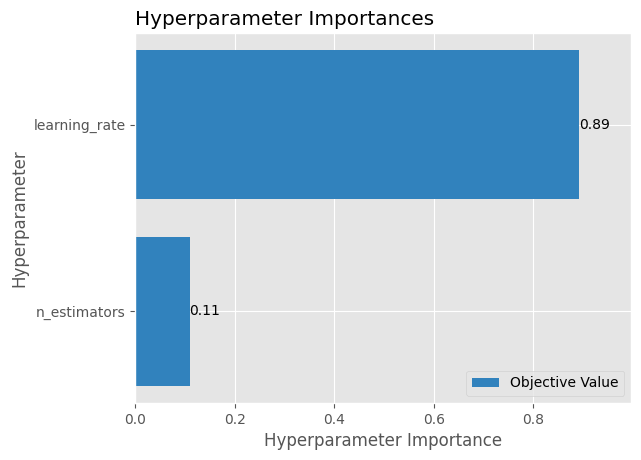

In [105]:
# Visualization of hyperparameter importance
optuna.visualization.matplotlib.plot_param_importances(study_adaboost)
plt.show()

In [106]:
# Training AdaBoost Classifier with best hyperparameters
adaboost_model_BO = AdaBoostClassifier(n_estimators = study_adaboost.best_params['n_estimators'], learning_rate = study_adaboost.best_params['learning_rate'])
adaboost_model_BO.fit(X_train, y_train)

AdaBoostClassifier(learning_rate=0.9328830445906785, n_estimators=427)

Adaboostclassifier model with TPE-Based Optimization

              precision    recall  f1-score   support

           0       0.83      0.87      0.85       194
           1       0.56      0.49      0.52        68

    accuracy                           0.77       262
   macro avg       0.69      0.68      0.68       262
weighted avg       0.76      0.77      0.76       262



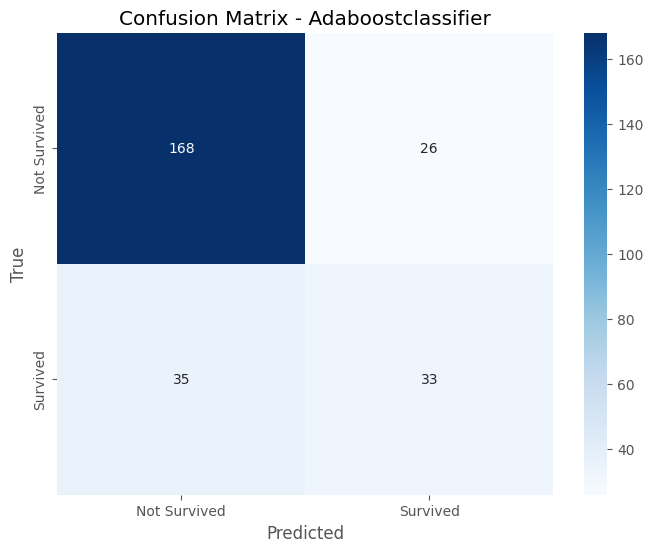

In [107]:
# Evaluating the model
y_pred = adaboost_model_BO.predict(X_test)
print("Adaboostclassifier model with TPE-Based Optimization\n")
print(classification_report(y_test, y_pred))
conf_mat = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Survived','Survived'], yticklabels=['Not Survived', "Survived"])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title(f'Confusion Matrix - Adaboostclassifier')
plt.show()

In [108]:
best_classif_model = adaboost_model_BO
best_classif_model

AdaBoostClassifier(learning_rate=0.9328830445906785, n_estimators=427)

### **Step 4: Making Predictions**

In [109]:
prediction = best_classif_model.predict(X_test)
prediction = pd.DataFrame(prediction, columns = ["Predicted_Survived"])
eval_classif_df = pd.concat([y_test.reset_index(drop=True), prediction.reset_index(drop=True)], axis=1)
eval_classif_df

,Survived,Predicted_Survived
0,0,0
1,0,1
2,0,1
3,0,0
4,0,0
...,...,...
257,0,0
258,1,1
259,0,0
260,0,0


## **Part 4: Regression Task (House Prices Dataset)**

### **Step 1: Splitting Data**


In [186]:
X = car_prices_scaled.drop(columns=['Price'])
y = car_prices_scaled['Price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [187]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((8000, 48), (2000, 48), (8000,), (2000,))

In [188]:
scaler_y = StandardScaler()
y_train = scaler_y.fit_transform(pd.DataFrame(y_train))
y_test = scaler_y.transform(pd.DataFrame(y_test))

### **Step 2: Train Regression Models using Bayesian optimization**


#### **SVR**

In [142]:
# Defining objective function of SVR
def objective_SVR(trial):
  C = trial.suggest_loguniform("C", 0.01, 100)
  epsilon = trial.suggest_loguniform("epsilon", 0.001, 10)
  gamma = trial.suggest_loguniform("gamma", 0.0001, 1.0)
  kernel = trial.suggest_categorical("kernel", ["linear","poly","rbf","sigmoid"])

  svr_model = SVR(C = C, epsilon = epsilon, gamma = gamma, kernel = kernel)
  svr_model.fit(X_train, y_train)

  y_pred = svr_model.predict(X_test)
  mse = mean_squared_error(y_test, y_pred)

  return mse

In [143]:
# Run TPE-based Bayesian Optimizer
study = optuna.create_study(direction = "minimize", sampler = optuna.samplers.TPESampler())
study.optimize(objective_SVR, n_trials = 50)

[I 2025-04-12 15:23:35,301] A new study created in memory with name: no-name-08eb5809-3f0b-476f-828a-7a9d348e40ae
<ipython-input-142-740479f9c5d6>:3: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C = trial.suggest_loguniform("C", 0.01, 100)
<ipython-input-142-740479f9c5d6>:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  epsilon = trial.suggest_loguniform("epsilon", 0.001, 10)
<ipython-input-142-740479f9c5d6>:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  gamma = trial.suggest_loguniform("gamma", 0.0001, 1.0)


In [144]:
# Print best hyperparameters
print("Best hyperparameters:", study.best_params)
print("Best MSE:", study.best_value)

Best hyperparameters: {'C': 13.02512373956153, 'epsilon': 0.005872726058239901, 'gamma': 0.051010188340753645, 'kernel': 'rbf'}
Best MSE: 0.0002922067865654639


<ipython-input-145-dee6a042c243>:2: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_optimization_history(study)


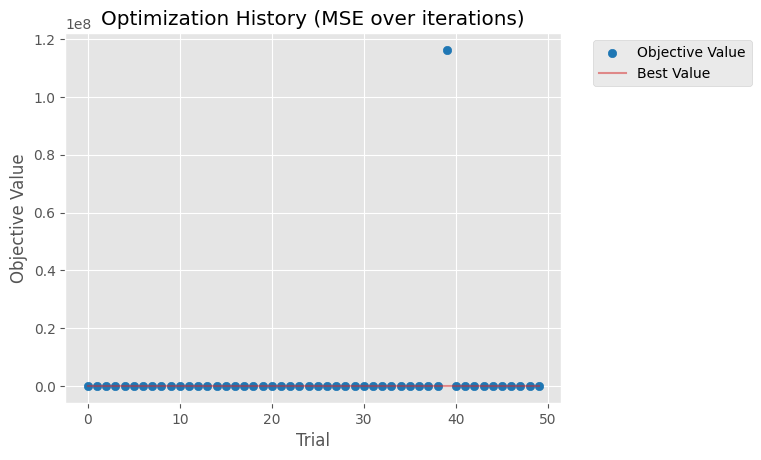

In [145]:
# visualization of optimization History
optuna.visualization.matplotlib.plot_optimization_history(study)
plt.title("Optimization History (MSE over iterations)")
plt.show()

<ipython-input-146-881a1234aa58>:2: ExperimentalWarning: plot_param_importances is experimental (supported from v2.2.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_param_importances(study)


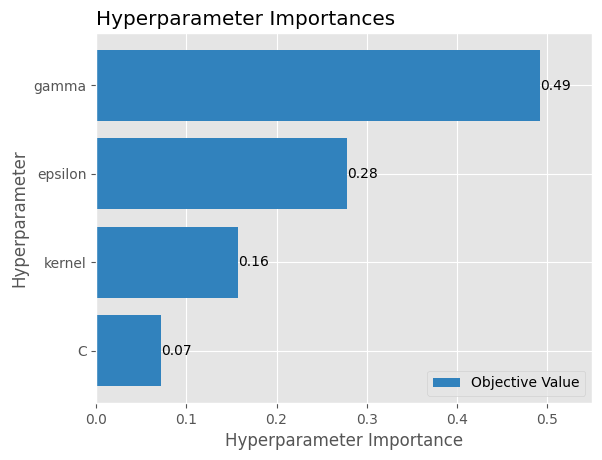

In [146]:
# Visualization of hyperparameter Importance
optuna.visualization.matplotlib.plot_param_importances(study)
plt.show()

In [147]:
study.trials_dataframe()

,number,value,datetime_start,datetime_complete,duration,params_C,params_epsilon,params_gamma,params_kernel,state
0,0,6.168922e-01,2025-04-12 15:23:35.303367,2025-04-12 15:23:36.265267,0 days 00:00:00.961900,0.010877,1.210520,0.009376,sigmoid,COMPLETE
1,1,2.380018e-01,2025-04-12 15:23:36.266734,2025-04-12 15:23:36.300789,0 days 00:00:00.034055,3.954314,1.228900,0.009277,sigmoid,COMPLETE
2,2,5.041912e-01,2025-04-12 15:23:36.301972,2025-04-12 15:23:43.072381,0 days 00:00:06.770409,0.015600,0.001289,0.003040,sigmoid,COMPLETE
3,3,9.381961e-01,2025-04-12 15:23:43.073598,2025-04-12 15:23:46.481029,0 days 00:00:03.407431,0.089828,0.090051,0.001222,poly,COMPLETE
4,4,2.048744e-03,2025-04-12 15:23:46.482214,2025-04-12 15:23:47.572288,0 days 00:00:01.090074,3.793453,0.105387,0.000918,linear,COMPLETE
5,5,9.393625e-01,2025-04-12 15:23:47.573537,2025-04-12 15:23:48.138762,0 days 00:00:00.565225,0.102465,1.432218,0.002275,poly,COMPLETE
6,6,5.522018e-03,2025-04-12 15:23:48.139972,2025-04-12 15:23:48.366172,0 days 00:00:00.226200,0.235780,0.177832,0.001245,linear,COMPLETE
7,7,2.979652e-01,2025-04-12 15:23:48.367354,2025-04-12 15:23:48.395301,0 days 00:00:00.027947,0.432763,1.387435,0.064313,sigmoid,COMPLETE
8,8,9.382815e-01,2025-04-12 15:23:48.396438,2025-04-12 15:23:52.964983,0 days 00:00:04.568545,0.450996,0.014652,0.000467,poly,COMPLETE
9,9,6.413604e-02,2025-04-12 15:23:52.970906,2025-04-12 15:23:53.351305,0 days 00:00:00.380399,1.108828,0.428218,0.010379,linear,COMPLETE


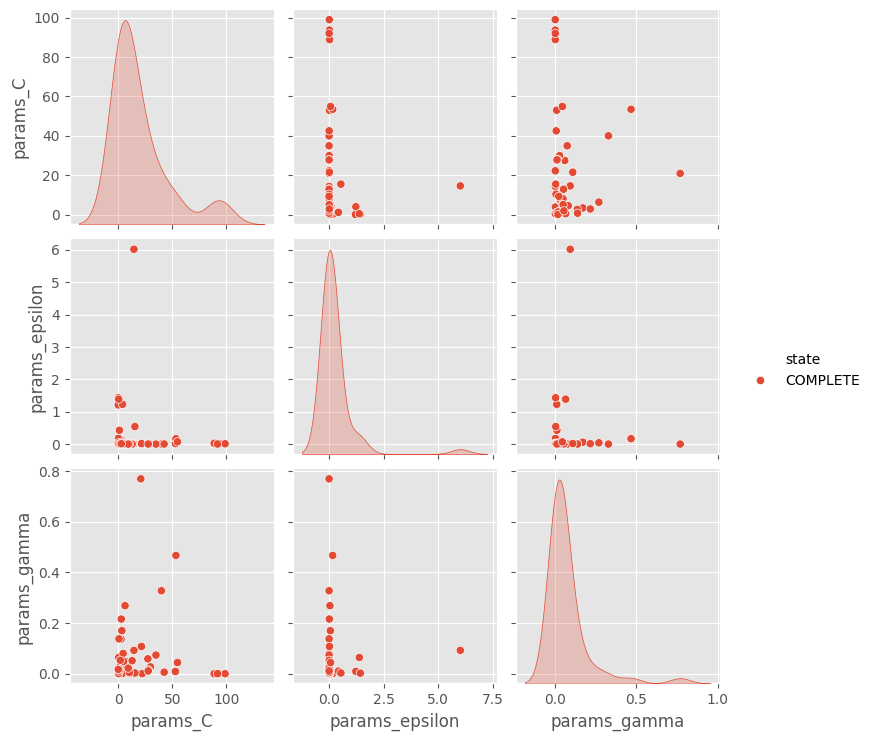

In [148]:
# Visualization of hyperparameter distribution
df_param_Imp = study.trials_dataframe()
sns.pairplot(df_param_Imp, vars = ["params_C", "params_epsilon", "params_gamma"], hue = "state")
plt.show()

In [149]:
# Training SVR model with best hyperparameters
best_svr_model = SVR(C = study.best_params["C"], epsilon = study.best_params["epsilon"],
                     gamma = study.best_params["gamma"], kernel = study.best_params["kernel"])
best_svr_model.fit(X_train, y_train)

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SVR(C=13.02512373956153, epsilon=0.005872726058239901,
    gamma=0.051010188340753645)

In [150]:
# Evaluating final SVR model
y_pred = best_svr_model.predict(X_test)
r2_svr_model = r2_score(y_test,y_pred)
r2_svr_model

0.9996880298934385

#### **RandomForestRegressor**

In [151]:
# Defining the Objective function of RandomForestRegressor
def objective_rf(trial):
  n_estimators = trial.suggest_int("n_estimators", 100, 1000)
  max_depth = trial.suggest_int("max_depth", 1, 20)
  min_samples_split = trial.suggest_int("min_samples_split", 2, 15)
  min_samples_leaf = trial.suggest_int("min_samples_leaf", 1, 10)
  max_features = trial.suggest_categorical("max_features", ["sqrt","log2", None])

  rf_model = RandomForestRegressor(n_estimators = n_estimators, max_depth = max_depth,
                                   min_samples_split=min_samples_split, min_samples_leaf=min_samples_leaf,
                                   max_features=max_features)
  rf_model.fit(X_train, y_train)

  y_pred = rf_model.predict(X_test)
  mse = mean_squared_error(y_test, y_pred)

  return mse

In [152]:
# Running TPE-based Bayesian optimization
study_rf = optuna.create_study(direction= "minimize", sampler = optuna.samplers.TPESampler())
study_rf.optimize(objective_rf, n_trials = 50)

[I 2025-04-12 15:41:08,055] A new study created in memory with name: no-name-f9a03652-4ae2-49e5-8785-3f3f36f344e3
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
[I 2025-04-12 15:41:13,964] Trial 0 finished with value: 0.17730607713870905 and parameters: {'n_estimators': 858, 'max_depth': 19, 'min_samples_split': 4, 'min_samples_leaf': 8, 'max_features': 'log2'}. Best is trial 0 with value: 0.17730607713870905.
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
[I 2025-04-12 15:41:22,955] Trial 1 finished with value: 0.08446380340866273 and parameters: {'n_estima

In [153]:
print("Best hyperparameters:", study_rf.best_params)
print("Best MSE:", study_rf.best_value)

Best hyperparameters: {'n_estimators': 102, 'max_depth': 16, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': None}
Best MSE: 0.02734886303434955


<ipython-input-154-31b905f4878b>:2: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_optimization_history(study_rf)


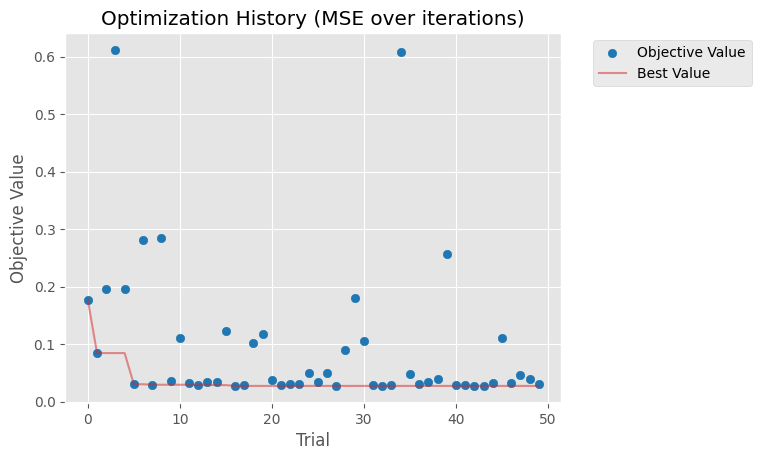

In [154]:
# Visualization of optimization history
optuna.visualization.matplotlib.plot_optimization_history(study_rf)
plt.title("Optimization History (MSE over iterations)")
plt.show()

<ipython-input-155-f771ff6c96ea>:2: ExperimentalWarning: plot_param_importances is experimental (supported from v2.2.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_param_importances(study_rf)


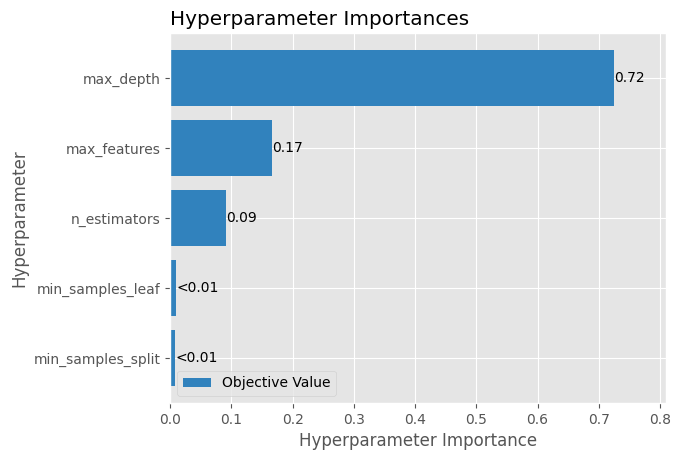

In [155]:
# Visualization of hyperparameter importance
optuna.visualization.matplotlib.plot_param_importances(study_rf)
plt.show()

In [156]:
# Training RandomForestRegressor model with best hyperparameters
best_rf_model = RandomForestRegressor(n_estimators = study_rf.best_params['n_estimators'], max_depth= study_rf.best_params['max_depth'],
                                      min_samples_split = study_rf.best_params['min_samples_split'], min_samples_leaf = study_rf.best_params['min_samples_leaf'],
                                      max_features = study_rf.best_params['max_features'])
best_rf_model.fit(X_train, y_train)

/usr/local/lib/python3.11/dist-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


RandomForestRegressor(max_depth=16, max_features=None, min_samples_leaf=2,
                      n_estimators=102)

In [157]:
# Evaluating model
y_pred = best_rf_model.predict(X_test)
r2_rf_model = r2_score(y_test,y_pred)
r2_rf_model

0.9705577699400896

#### **MLPRegressor**

In [158]:
# Defining objective function of MLPRegressor
def objective_mlp(trial):
  n_layers = trial.suggest_int("n_layers", 1, 3)  # Nombre de couches (entre 1 et 3)
  hidden_layer_sizes = tuple(trial.suggest_int(f"n_units_l{i}", 10, 200) for i in range(n_layers))
  activation = trial.suggest_categorical("activation", ["relu","tanh","logistic", "identity"])
  solver = trial.suggest_categorical("solver", ["adam", "lbfgs", "sgd"])
  learning_rate = trial.suggest_categorical("learning_rate", ["constant", "invscaling", "adaptive"])
  alpha = trial.suggest_loguniform("alpha", 0.0001, 1.0)
  max_iter = trial.suggest_int("max_iter", 100, 1000)
  early_stopping = trial.suggest_categorical("early_stopping", [True, False])

  mlp_model = MLPRegressor(hidden_layer_sizes=hidden_layer_sizes, activation=activation, solver=solver,
                           learning_rate=learning_rate, alpha=alpha, max_iter=max_iter, early_stopping=early_stopping)
  mlp_model.fit(X_train, y_train)

  y_pred = mlp_model.predict(X_test)
  mse = mean_squared_error(y_test, y_pred)

  return mse

In [159]:
y_train

array([[ 0.28488624],
       [ 0.18303337],
       [-0.09506649],
       ...,
       [ 0.15589389],
       [-0.26556629],
       [-0.01428662]])

In [160]:
y_test

array([[-2.18033649],
       [ 0.74561885],
       [ 1.85227109],
       ...,
       [-0.22501671],
       [-0.67680925],
       [ 0.96624686]])

In [161]:
# Running Bayesian Optimization
study_mlp = optuna.create_study(direction="minimize", sampler=optuna.samplers.TPESampler())
study_mlp.optimize(objective_mlp, n_trials=50)

[I 2025-04-12 15:48:51,648] A new study created in memory with name: no-name-a09d6c50-43e3-43ac-bb11-aa6a823ccd13
<ipython-input-158-e54ff979d8ea>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  alpha = trial.suggest_loguniform("alpha", 0.0001, 1.0)
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1650: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
[I 2025-04-12 15:48:52,069] Trial 0 finished with value: 0.00043559617644857484 and parameters: {'n_layers': 1, 'n_units_l0': 56, 'activation': 'identity', 'solver': 'lbfgs', 'learning_rate': 'constant', 'alpha': 0.001790280761821321, 'max_iter': 676, 'early_stopping': True}. Best is trial 0 with value:

In [162]:
print("Best Hyperparameters:", study_mlp.best_params)
print("Best MSE:", study_mlp.best_value)

Best Hyperparameters: {'n_layers': 1, 'n_units_l0': 178, 'activation': 'logistic', 'solver': 'adam', 'learning_rate': 'constant', 'alpha': 0.0036358869304687646, 'max_iter': 574, 'early_stopping': False}
Best MSE: 0.0003348141659107019


<ipython-input-163-737ca00f2a4c>:2: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_optimization_history(study_mlp)


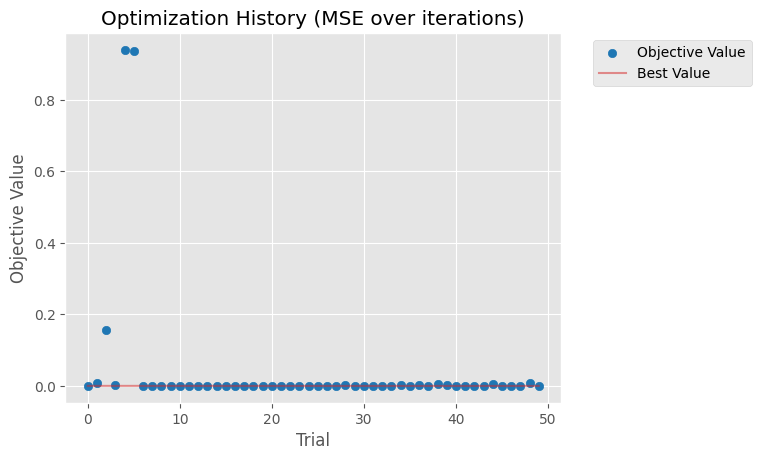

In [163]:
# Visualization of optimization history
optuna.visualization.matplotlib.plot_optimization_history(study_mlp)
plt.title("Optimization History (MSE over iterations)")
plt.show()

<ipython-input-164-a3bff135960d>:2: ExperimentalWarning: plot_param_importances is experimental (supported from v2.2.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_param_importances(study_mlp)


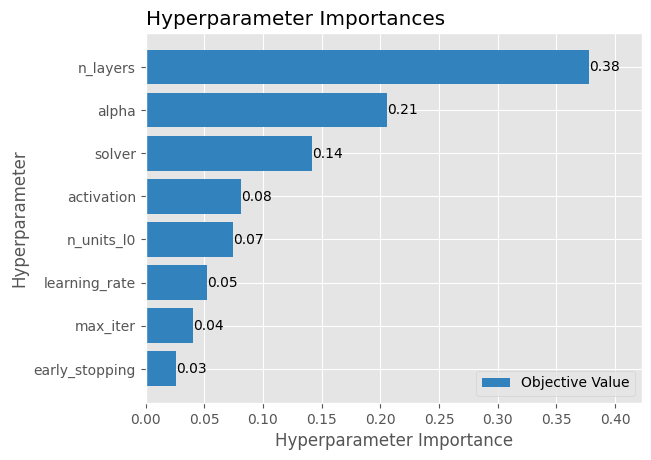

In [164]:
# Visualization of hyperparameter importance
optuna.visualization.matplotlib.plot_param_importances(study_mlp)
plt.show()

In [165]:
# Training MLPRegressor with best Hyperparameters
best_mlp_model = MLPRegressor(hidden_layer_sizes=tuple(study_mlp.best_params[f"n_units_l{i}"] for i in range(study_mlp.best_params["n_layers"])),
                              activation=study_mlp.best_params["activation"], solver=study_mlp.best_params["solver"],
                              learning_rate=study_mlp.best_params["learning_rate"], alpha=study_mlp.best_params["alpha"],
                              max_iter=study_mlp.best_params["max_iter"], early_stopping=study_mlp.best_params["early_stopping"])
best_mlp_model.fit(X_train, y_train)

/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1650: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MLPRegressor(activation='logistic', alpha=0.0036358869304687646,
             hidden_layer_sizes=(178,), max_iter=574)

In [166]:
# Evaluating MLPRegressor model
y_pred = best_mlp_model.predict(X_test)
r2_mlp_model = r2_score(y_test,y_pred)
r2_mlp_model

0.9996341019493871

#### **Linear Regression**

In [167]:
# Training LinearRegressor model
lin_reg_model = LinearRegression()
lin_reg_model.fit(X_train, y_train)

LinearRegression()

In [168]:
# Evaluating
y_pred = lin_reg_model.predict(X_test)
r2_lin_reg_model = r2_score(y_test,y_pred)
r2_lin_reg_model

0.999541357336514

### **Step 3: Model Evaluation**

In [169]:
# Displaying R2 score of each model in descending order
models = {'SVR': best_svr_model, 'RandomForestRegressor': best_rf_model,
          'MLPRegressor': best_mlp_model, 'LinearRegression': lin_reg_model}
eval_regression = []
for name, model in models.items():
    y_pred = model.predict(X_test)
    r2_scor = r2_score(y_test,y_pred)
    eval_regression.append([name, r2_scor])

eval_regression_df = pd.DataFrame(eval_regression, columns = ["Model","R2-score"])
eval_regression_df.sort_values(by = "R2-score", ascending = False, inplace = True)
eval_regression_df

,Model,R2-score
0,SVR,0.999688
2,MLPRegressor,0.999634
3,LinearRegression,0.999541
1,RandomForestRegressor,0.970558


As we can see, SVR performs the best on Regression task

In [190]:
best_regression_model = best_svr_model
best_regression_model

SVR(C=13.02512373956153, epsilon=0.005872726058239901,
    gamma=0.051010188340753645)

In [193]:
# Feature importance in predicting House price

carP_feature_names = X_train.columns

perm_importance = permutation_importance(
    best_regression_model,
    X_train,
    y_train,
    n_repeats=10,
    random_state=42
)

feature_importance = pd.DataFrame({
    'Features': carP_feature_names,
    'Importance': perm_importance.importances_mean
}).sort_values('Importance', ascending=False)

In [195]:
feature_importance["Importance"] = (feature_importance["Importance"]/feature_importance["Importance"].sum()) * 100
feature_importance

,Features,Importance
0,Year,40.783660
2,Mileage,28.594317
1,Engine_Size,12.662968
43,Fuel_Type_Electric,6.952891
46,Transmission_Manual,4.566570
47,Transmission_Semi-Automatic,4.503987
44,Fuel_Type_Hybrid,1.630614
5,Brand_BMW,0.037893
15,Model_A3,0.016756
35,Model_Q5,0.015548


### **Step 4: Making Predictions**

In [189]:
prediction = best_regression_model.predict(X_test)
prediction = pd.DataFrame(scaler_y.inverse_transform(prediction.reshape(-1,1)), columns = ["Predicted_Price"])
y_test = pd.DataFrame(scaler_y.inverse_transform(y_test.reshape(-1,1)), columns = ["Actual_Price"])
eval_reg_df = pd.concat([y_test.reset_index(drop=True), prediction.reset_index(drop=True)], axis=1)
eval_reg_df

,Actual_Price,Predicted_Price
0,2000.0,1810.790797
1,11164.0,11180.698927
2,14630.0,14602.293813
3,7334.0,7327.806124
4,10127.0,10125.160741
...,...,...
1995,4681.0,4700.392324
1996,12839.0,12841.207643
1997,8124.0,8122.297150
1998,6709.0,6682.138878
